In [169]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast.auxmodels import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(14,7)})

In [170]:
df = pd.read_excel("Case Prediction Data2.xlsx")

In [171]:
df_comp = df[df["Product"] == "Compliance"]
df_comp.head()

,Case Number,Subject,Date Created,Date Closed,Origin,Priority,Team,Case Type,SLA,Problem Statement,Product,Product Area,Product Category,Product Type,Jurisdiction,Resolution,KB #,KB Title
0,204977,Efile Acceptance,2017-01-02 05:39:00,2017-01-03 09:03:00,Web,Medium,Tax Preparation,Efile,Platinum,We transmitted a Michigan return still have not received the acceptance/rejection confirmation.,Compliance,Returns / Reports,NaN,NaN,US.MI,Answer exists KB,041324813494120,How to understand the Transmission Monitor
4,204986,LD400 is not reflecting a temporary adjustment,2017-01-03 07:17:00,2017-01-05 08:21:00,E-mail,Medium,Tax Preparation,Problem / Error,Platinum,LD400 is not reflecting a temporary adjustment,Compliance,Returns / Reports,NaN,NaN,US,Answer exists KB,041622907012748,Adjustments do not flow to LD400 workpaper and Taxable income per the LD400 does not tie to the ...
6,204992,Form 2220 Line 19 dates.,2017-01-03 07:36:00,2017-01-10 09:16:00,Web,Medium,Tax Preparation,Problem / Error,Platinum,Form 2220 Line 19 dates are repeating. This is a fiscal year client and the quarterly date for p...,Compliance,Amounts,NaN,NaN,US,Answer exists KB,041335414275440,IRS e-Services and Business MeF Maintenance including states
8,204997,Corptax Upgrade File,2017-01-03 08:15:00,2017-01-03 11:36:00,Web,Medium,IT / Systems,Question / How To,Silver,provide MSI Files,Compliance,Install / Rollover,Provide Corptax Client MSI Files,NaN,NaN,Answer exists KB,NaN,NaN
10,205001,Share the MSI files for Corptax 2016.2,2017-01-03 08:24:00,2017-01-03 11:30:00,Web,Medium,IT / Systems,Question / How To,Gold,provide MSI Files,Compliance,Install / Rollover,Provide Corptax Client MSI Files,NaN,NaN,Answer exists KB,NaN,NaN


In [172]:
#dfc = df[df.Product == "Compliance"]
df_comp['Date Created'] = df_comp['Date Created'].dt.date
df_comp['Date Closed'] = df_comp['Date Closed'].dt.date
df_comp['Date'] = pd.to_datetime(df_comp['Date Created'], errors='coerce')
dfc = df_comp

In [173]:
# Adding a new column which will have the number of tickets per day
newdf = dfc[["Date","Case Number"]]
newdf.drop_duplicates(inplace=True)
newdf['Date'] = pd.to_datetime(newdf['Date'])
newdf = pd.DataFrame(newdf.groupby([newdf["Date"].dt.date]).count()["Case Number"])
newdf = newdf.reset_index()
newdf.index = newdf.Date
newdf['Date'] = pd.to_datetime(newdf['Date'], errors='coerce')
newdf = newdf.asfreq('D')
newdf = newdf.groupby(pd.Grouper(freq="M")).sum()
newdf

,Case Number
Date,
2017-01-31,1066.0
2017-02-28,1300.0
2017-03-31,2092.0
2017-04-30,1247.0
2017-05-31,1407.0
...,...
2022-04-30,914.0
2022-05-31,777.0
2022-06-30,952.0


In [174]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68 entries, 2017-01-31 to 2022-08-31
Freq: M
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Case Number  68 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


In [175]:
f = Forecaster(y=newdf['Case Number'],current_dates=newdf.index)
f

Forecaster(
    DateStartActuals=2017-01-31T00:00:00.000000000
    DateEndActuals=2022-08-31T00:00:00.000000000
    Freq=M
    N_actuals=68
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

In [144]:
f.generate_future_dates(12)
f.set_test_length(.2)
f.set_estimator('arima')
f.manual_forecast(call_me='arima1')

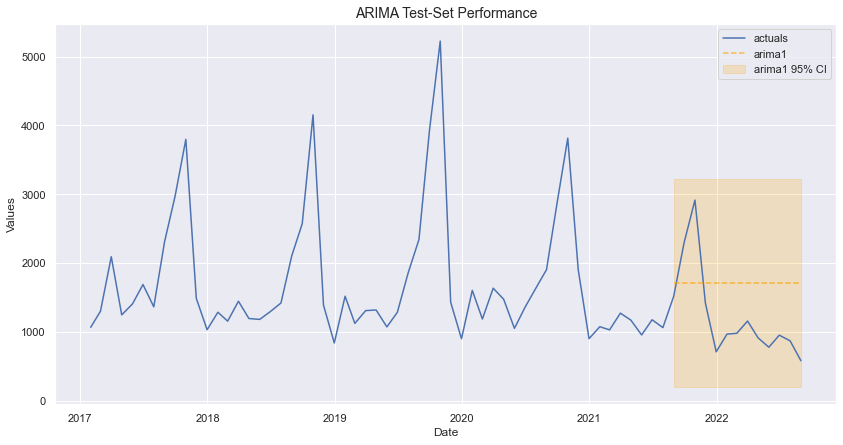

In [145]:
f.plot_test_set(ci=True)
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

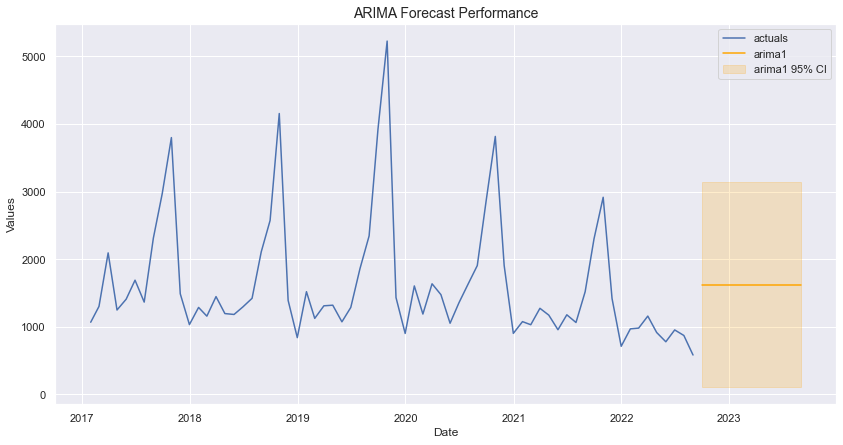

In [146]:
f.plot(ci=True)
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

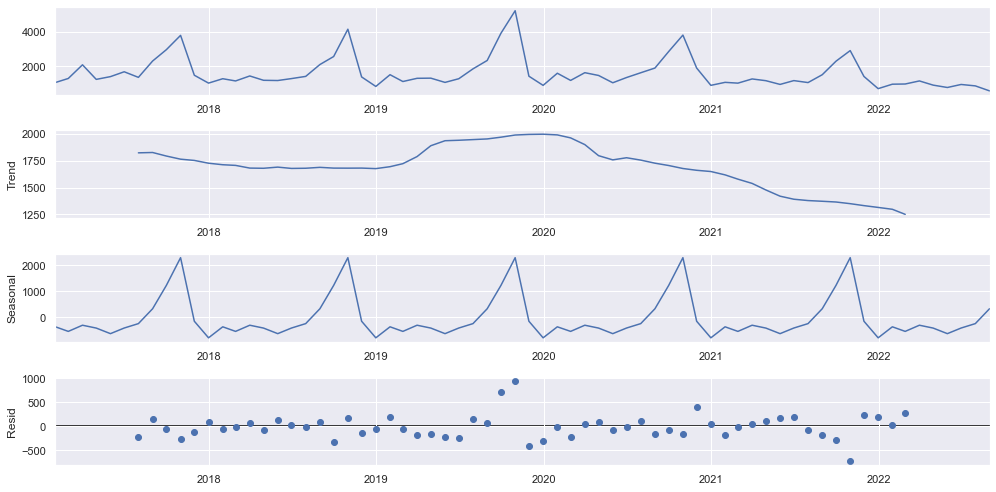

In [147]:
f.seasonal_decompose().plot()
plt.show()

In [148]:
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print(stat)
print(pval)

1.0148828917510513
0.9944205244966136


In [149]:
f.manual_forecast(order=(1,1,1),seasonal_order=(2,1,1,12),call_me='arima2')

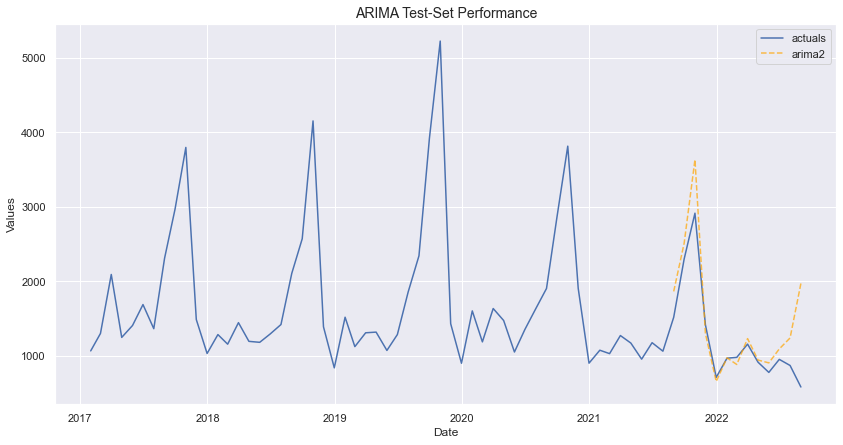

In [150]:
f.plot_test_set(ci=False,models='arima2')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

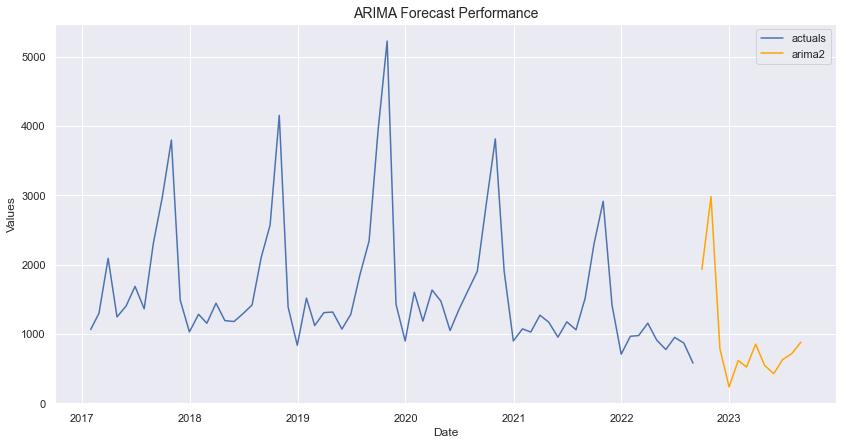

In [151]:
f.plot(ci=False,models='arima2')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

In [152]:
f.regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                   68
Model:             ARIMA(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -403.179
Date:                          Fri, 26 Aug 2022   AIC                            818.359
Time:                                  16:24:17   BIC                            830.403
Sample:                                       0   HQIC                           823.016
                                           - 68                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3300      0.329      1.003      0.316      -0.315       0.975
ma.L1         -0.8500      0.194     -4.392      0.000      -1.229      -0.471
ar.S.L12       0.3247      0.147      2.213      0.027       0.037       0.612
ar.S.L24      -0.2750      0.182     -1.509      0.131      -0.632       0.082
ma.S.L12      -0.9875      0.165     -6.002      0.000      -1.310      -0.665
sigma2      9.368e+04   1.84e-06   5.08e+10      0.000    9.37e+04    9.37e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                14.26
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.62
Prob(H) (two-sided):                  0.91   Kurtosis:                         5.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.09e+26. Standard errors may be unstable.
"""

# Auto-ARIMA Approach

In [153]:
auto_arima(
    f,
    start_P=1,
    start_q=1,
    max_p=6,
    max_q=6,
    m=12,
    seasonal=True,
    max_P=2, 
    max_D=2,
    max_Q=2,
    max_d=2,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion="aic",
    alpha=0.05,
    scoring='mse',
    call_me='arima3',
)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=652.143, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=642.270, Time=0.17 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=650.919, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=645.736, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=643.558, Time=0.35 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=644.076, Time=0.13 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=644.263, Time=0.24 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=640.515, Time=0.30 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=643.747, Time=0.17 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=642.151, T

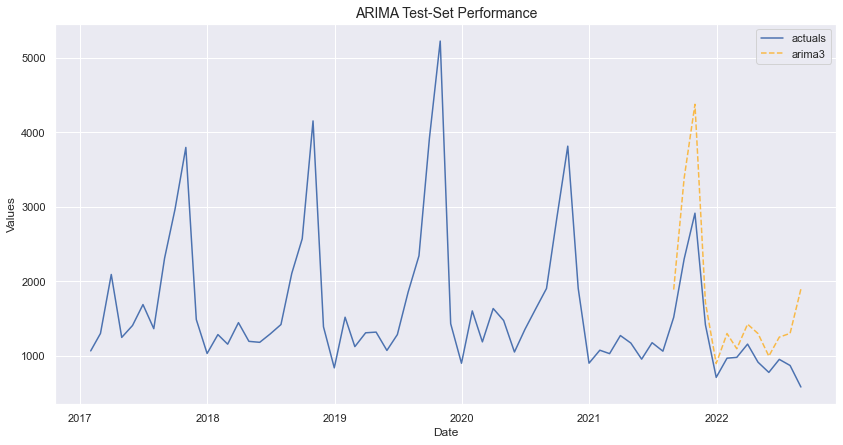

In [154]:
f.plot_test_set(ci=False,models='arima3')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

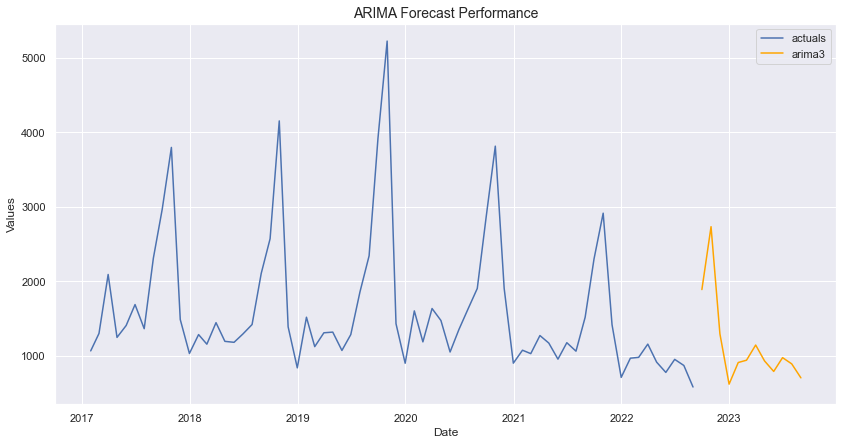

In [155]:
f.plot(ci=False,models='arima3')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

In [156]:
pd.options.display.max_colwidth = 100
results = f.export(to_excel=True,
                   excel_name='arima_results.xlsx',
                   determine_best_by='TestSetMAPE')

In [162]:
results["lvl_test_set_predictions"]

,DATE,actual,arima2,arima3,arima1
55,2021-08-31,1517.0,1864.583179,1889.436807,1711.981871
56,2021-09-30,2300.0,2511.477406,3386.024467,1711.981871
57,2021-10-31,2915.0,3633.539862,4377.117595,1711.981871
58,2021-11-30,1417.0,1299.856642,1718.021872,1711.981871
59,2021-12-31,710.0,655.024484,895.707528,1711.981871
60,2022-01-31,968.0,972.754895,1298.928629,1711.981871
61,2022-02-28,979.0,883.125150,1094.670314,1711.981871
62,2022-03-31,1157.0,1230.653855,1424.927616,1711.981871
63,2022-04-30,914.0,942.788336,1298.279566,1711.981871
64,2022-05-31,777.0,904.774353,995.411103,1711.981871


In [160]:
results["test_set_predictions"]

,DATE,actual,arima2,arima3,arima1
55,2021-08-31,1517.0,1864.583179,1889.436807,1711.981871
56,2021-09-30,2300.0,2511.477406,3386.024467,1711.981871
57,2021-10-31,2915.0,3633.539862,4377.117595,1711.981871
58,2021-11-30,1417.0,1299.856642,1718.021872,1711.981871
59,2021-12-31,710.0,655.024484,895.707528,1711.981871
60,2022-01-31,968.0,972.754895,1298.928629,1711.981871
61,2022-02-28,979.0,883.125150,1094.670314,1711.981871
62,2022-03-31,1157.0,1230.653855,1424.927616,1711.981871
63,2022-04-30,914.0,942.788336,1298.279566,1711.981871
64,2022-05-31,777.0,904.774353,995.411103,1711.981871


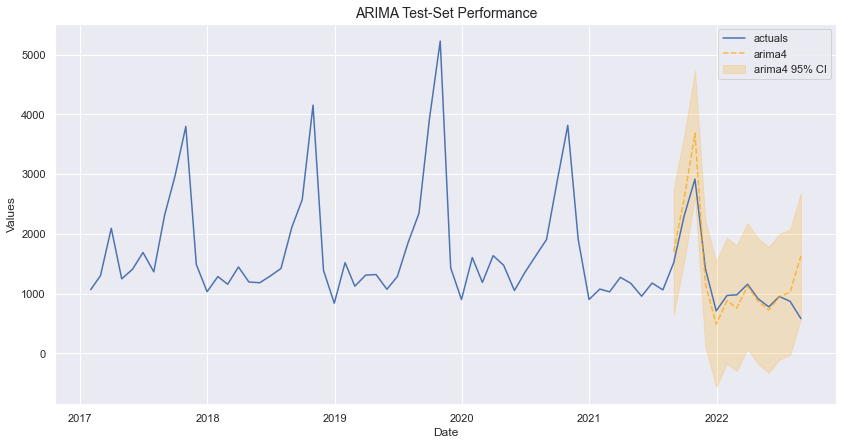

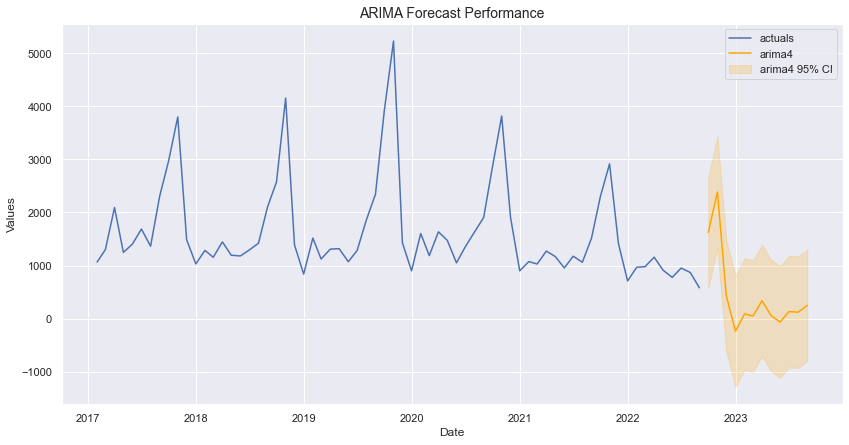

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   68
Model:             ARIMA(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -408.452
Date:                            Fri, 26 Aug 2022   AIC                            824.904
Time:                                    16:29:44   BIC                            832.933
Sample:                                         0   HQIC                           828.009
                                             - 68                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2737      0.188     -1.454      0.146      -0.643       0.095
ar.S.L12       0.3900      0.330      1.182      0.237      -0.257       1.037
ma.S.L12      -0.9902     10.486     -0.094      0.925     -21.541      19.561
sigma2      1.333e+05   1.36e+06      0.098      0.922   -2.53e+06     2.8e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):                12.44
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.46
Prob(H) (two-sided):                  0.54   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [163]:
f.set_validation_length(12)
grid = {
    'order':[(1,1,1),(1,1,0),(0,1,1)],
    'seasonal_order':[(2,1,1,12),(1,1,1,12),(2,1,0,12),(0,1,0,12)]
}

f.ingest_grid(grid)
f.tune()
f.auto_forecast(call_me='arima4')

f.plot_test_set(ci=True,models='arima4')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

f.plot(ci=True,models='arima4')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

f.regr.summary()

In [164]:
pd.options.display.max_colwidth = 100
results = f.export(to_excel=True,
                   excel_name='arima_results.xlsx',
                   determine_best_by='TestSetMAPE')

In [165]:
results.keys()

dict_keys(['model_summaries', 'best_fcst', 'all_fcsts', 'test_set_predictions', 'lvl_fcsts', 'lvl_test_set_predictions'])

In [167]:
results["all_fcsts"]

,DATE,arima1,arima2,arima3,arima4
0,2022-09-30,1620.819437,1932.067910,1889.421139,1625.693075
1,2022-10-31,1620.819437,2981.945128,2733.757837,2382.789529
2,2022-11-30,1620.819437,791.024890,1294.865269,430.849719
3,2022-12-31,1620.819437,236.550741,619.085756,-235.628436
4,2023-01-31,1620.819437,619.801875,909.955076,90.661312
5,2023-02-28,1620.819437,525.169692,940.730385,48.910194
6,2023-03-31,1620.819437,854.534913,1144.475346,338.270787
7,2023-04-30,1620.819437,549.847584,931.090655,62.277341
8,2023-05-31,1620.819437,428.037525,790.075445,-64.500533
9,2023-06-30,1620.819437,631.389797,975.325472,133.178434
